<a href="https://colab.research.google.com/github/paultanmoy005/1DCNN_StVincent/blob/main/Colab%20Notebooks/rawECG_StVincent_ApneaECG_for_figure_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook combines both St. Vincent and ApneaECG ECG dataset**

In [ ]:
!pip3 install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
# import the libraries 
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import train_test_split
from keras import regularizers, initializers
from keras.layers import *
from keras.constraints import *
from keras.models import Sequential, load_model
from sklearn.metrics import *
from matplotlib import pyplot
from keras import backend as K
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from google.colab import drive
from copy import deepcopy
from keras.models import Model
import wfdb

In [ ]:
# mount the data drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Apnea Data/St. Vincent Hospital/RawECGandAnnot_12Sec_10Thresh.csv'

Mounted at /content/drive


In [ ]:
# read the data
data = pd.read_csv(path,header=None)
x = data.iloc[:,0:1536]
y = data.iloc[:,1536]

In [ ]:
# Record name for ApneaECG dataset
path = '/content/drive/My Drive/Apnea Data/apnea-ecg-database-1.0.0/'
A1 = ["a0%d" %i for i in range(1,10)]
A2 = ["a%d" %i for i in range(10,21)]
B = ["b0%d" %i for i in range(1,6)]
C = ["c0%d" %i for i in range(1,10)]
X1 = ["x0%d" %i for i in range(1,10)]
X2 = ["x%d" %i for i in range(10,36)]
Record = [A1 + A2 + B + C + ["c10"] + X1 + X2][0]

In [ ]:
# def rriCalculation(start, end):
#     rpeaksSlice = [j for j in rpeaks if j >= start and j < end]
#     RRI = [rpeaksSlice[i + 1] - rpeaksSlice[i] for i in range(len(rpeaksSlice) - 1)]
#     return RRI

# storeAll = []
# for record in Record[:35]:
#   fileIn = path + record
#   annotQrs = wfdb.io.rdann(fileIn, 'qrs')
#   rpeaks = annotQrs.sample
#   annot_apnea = wfdb.io.rdann(fileIn, 'apn')
#   annotation = annot_apnea.symbol
#   count = 0
#   fs = 100
#   interval = 6000
#   procWindow = 30*fs
#   # we will take the 30 second segment based on three conditions:
#   # 1. Whether it is from the first minute of the entire recording
#   # 2. Whether it is from the last minute of the entire recording
#   # 3. Whether it is from any other minute
#   while count < len(annotation):
#     if count == 0 or count != len(annotation)-1:
#       start1 = interval * count
#       end1 = start1 + procWindow
#       rri = rriCalculation(start1, end1)
#       storeAll.append(rri)
#     count += 1

In [ ]:
# segmentation of the signal into segments of 15s
storeSegment = []
storeAnnotation = []
minute = 6000
fs = 100
segmentLength = int(15.36*fs)
for record in Record:
  fileIn = path + record
  annot_apnea = wfdb.io.rdann(fileIn, 'apn')
  annotation = annot_apnea.symbol
  signal, info= wfdb.io.rdsamp(fileIn)
  for j in range(len(annotation)):
    minuteSignal = signal[j*minute:j*minute+minute].ravel()
    windowSignal = list(minuteSignal[:segmentLength])
    if len(windowSignal)==segmentLength:
      storeSegment.append(windowSignal)
      storeAnnotation += annotation[j]
  if record == 'c10':
    trainLen = len(storeSegment)
    print(f'Total number of Training Segment: {trainLen}')
  if record == 'x35':
    print(f'Total number of Testing Segment: {len(storeSegment)-trainLen}')

Total number of Training Segment: 17035
Total number of Testing Segment: 17263


In [ ]:
storeAnnotation = [0 if i=='N' else 1 for i in storeAnnotation]
for i in range(x.shape[0]):
  storeSegment.append(list(x.iloc[i,:]))
  storeAnnotation.append(y[i])

In [ ]:
# # Normalize the entire dataset, resample and split the set into train and test set
scale = StandardScaler()
x = scale.fit_transform(storeSegment)
# ros = RandomOverSampler(random_state =2)
sm = SMOTE(random_state = 42)
x, y = sm.fit_resample(x,storeAnnotation)
#del storeSegment 
#del storeAnnotation
xTrainFinal, xTestFinal, yTrainFinal, yTestFinal = train_test_split(x, y, test_size = 0.1, random_state=42)
xTrainFinal, xValFinal, yTrainFinal, yValFinal = train_test_split(xTrainFinal, yTrainFinal, test_size = 0.1, random_state=42)

In [ ]:
#check the class distribution
apnea = len(np.where(np.array(yTrainFinal)==1)[0])
normal = len(np.where(np.array(yTrainFinal)==0)[0])
print(f'There are a total of {apnea} and {normal} class')

There are a total of 54311 and 54160 class


In [ ]:
# # Reshape the data
# xTrainFinal = np.reshape(xTrainFinal,(xTrainFinal.shape[0],xTrainFinal.shape[1],1))
# yTrainFinal = np.array([[1,0] if i==0 else [0,1] for i in yTrainFinal])
# xTestFinal = np.reshape(xTestFinal,(xTestFinal.shape[0],xTestFinal.shape[1],1))
# yTestFinal = np.array([[1,0] if i==0 else [0,1] for i in yTestFinal])
# xValFinal = np.reshape(xValFinal,(xValFinal.shape[0],xValFinal.shape[1],1))
# yValFinal = np.array([[1,0] if i==0 else [0,1] for i in yValFinal])

xTrainFinal = np.reshape(xTrainFinal,(xTrainFinal.shape[0],xTrainFinal.shape[1],1))
yTrainFinal = np.array([[0] if i==0 else [1] for i in yTrainFinal])
xTestFinal = np.reshape(xTestFinal,(xTestFinal.shape[0],xTestFinal.shape[1],1))
yTestFinal = np.array([[0] if i==0 else [1] for i in yTestFinal])
xValFinal = np.reshape(xValFinal,(xValFinal.shape[0],xValFinal.shape[1],1))
yValFinal = np.array([[0] if i==0 else [1] for i in yValFinal])

In [ ]:
# initialize the kernel
kernel1 = np.array([[[1,0]],[[0,1]]])
kernel2 = np.array([[[1,0,0]],[[0,1,0]],[[0,0,1]]])

In [ ]:
#define the model
input_shape=(xTrainFinal.shape[1],xTrainFinal.shape[2])
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Conv1D(3, (3), padding='valid', strides = 3, activation='relu', use_bias=False, weights=[kernel2], trainable=False)(x)
x = Conv1D(50, kernel_size=(3),strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=(3),strides=2)(x)
#x = Conv1D(2, (2), padding='valid', strides = 2, activation='relu', use_bias=False, weights=[np.tile(kernel,(1,200,1))], trainable=False)(x)
x = Conv1D(20, (3),activation='relu')(x)
x = MaxPooling1D(pool_size=(3),strides=1)(x)
#x = Conv1D(2, (2), padding='valid', strides = 2, activation='relu', use_bias=False, weights=[np.tile(kernel,(1,100,1))], trainable=False)(x)
x = Conv1D(20, (3),activation='relu')(x)
x = MaxPooling1D(pool_size=(2),strides=1)(x)
x = Conv1D(2, (2), padding='valid', strides = 2, activation='relu', use_bias=False, weights=[np.tile(kernel1,(1,20,1))], trainable=False)(x)
#x = Conv1D(50, (2),activation='relu')(x)
x = MaxPooling1D(pool_size=(3),strides=1)(x)
#x = Conv1D(2, (2), padding='valid', strides = 2, activation='relu', use_bias=False, weights=[np.tile(kernel,(1,50,1))], trainable=False)(x)
# x = Conv1D(5, (3),activation='relu')(x)
# x = MaxPooling1D(pool_size=(3),strides=2)(x)
#x = Conv1D(2, (2), padding='valid', strides = 2, activation='relu', use_bias=False, weights=[np.tile(kernel,(1,10,1))], trainable=True)(x)
#x = Conv1D(2, (3),activation='relu')(x)
# query = Dense(3)(x)
# key = Dense(3)(x)
# value = Dense(3)(x)

# score = Multiply()([query, key])
# attention_weights = Flatten()(Reshape((-1,))(score))
# attention_weights = Dense(x.shape[1], activation='softmax')(attention_weights)
# attention_weights = Reshape((x.shape[1], 1))(attention_weights)
# x = Multiply()([attention_weights, value])

x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
#model.add(Dense(2, kernel_initializer='he_uniform', activity_regularizer = regularizers.L2(0.01), kernel_regularizer= regularizers.L2(0.01), bias_regularizer= regularizers.L2(0.01), activation='softmax'))
#model.add(Dense(2, activation='softmax'))
output = Dense(1, activity_regularizer = regularizers.L2(0.02), kernel_regularizer= regularizers.L2(0.01), activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.summary()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1536, 1)]         0         
                                                                 
 batch_normalization_40 (Bat  (None, 1536, 1)          4         
 chNormalization)                                                
                                                                 
 conv1d_100 (Conv1D)         (None, 512, 3)            9         
                                                                 
 conv1d_101 (Conv1D)         (None, 510, 50)           500       
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 254, 50)          0         
 g1D)                                                            
                                                                 
 conv1d_102 (Conv1D)         (None, 252, 20)           302

In [ ]:
# kernel = np.array([[[1,0]],[[0,1]]])
# #define the model
# model = Sequential()
# model.add(BatchNormalization(input_shape=(xTrainFinal.shape[1],xTrainFinal.shape[2])))
# model.add(Conv1D(2, (2), padding='valid', strides = 2, activation=None, use_bias=False, weights=[kernel], trainable=False))
# model.add(Conv1D(100, kernel_size=(10),strides=2))
# model.add(Activation("relu"))
# model.add(MaxPooling1D(pool_size=(2),strides=2))
# model.add(Conv1D(2, (2), padding='valid', strides = 2, activation=None, use_bias=False, weights=[np.tile(kernel,(1,100,1))], trainable=False))
# model.add(Conv1D(75, (3)))
# model.add(MaxPooling1D(pool_size=(2),strides=1))
# model.add(Activation("relu"))
# model.add(Conv1D(2, (2), padding='valid', strides = 2, activation=None, use_bias=False, weights=[np.tile(kernel,(1,75,1))], trainable=False))
# model.add(Conv1D(75, (5)))
# model.add(MaxPooling1D(pool_size=(2),strides=1))
# model.add(Activation("relu"))
# model.add(Conv1D(2, (2), padding='valid', strides = 2, activation=None, use_bias=False, weights=[np.tile(kernel,(1,75,1))], trainable=False))
# #model.add(Conv1D(10, (5)))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Flatten())
# #model.add(Dropout(0.3))
# model.add(BatchNormalization())
# #model.add(Dense(2, kernel_initializer='he_uniform', activity_regularizer = regularizers.L2(0.1), kernel_regularizer= regularizers.L2(0.1), bias_regularizer= regularizers.L2(0.1), activation='softmax'))
# #model.add(Dense(2, kernel_initializer='he_uniform', activation='softmax'))
# model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
# model.summary()


In [ ]:
# Compile and fit the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy()])
history=model.fit(xTrainFinal, yTrainFinal, epochs=500, batch_size=1024, validation_data=(xValFinal,yValFinal), verbose=1)

Epoch 1/500
106/106 [==============================] - 5s 15ms/step - loss: 0.6094 - binary_accuracy: 0.7254 - val_loss: 0.5891 - val_binary_accuracy: 0.7543
Epoch 2/500
106/106 [==============================] - 1s 11ms/step - loss: 0.5227 - binary_accuracy: 0.7713 - val_loss: 0.5548 - val_binary_accuracy: 0.7776
Epoch 3/500
106/106 [==============================] - 1s 11ms/step - loss: 0.4824 - binary_accuracy: 0.7945 - val_loss: 0.5218 - val_binary_accuracy: 0.7995
Epoch 4/500
106/106 [==============================] - 1s 11ms/step - loss: 0.4564 - binary_accuracy: 0.8067 - val_loss: 0.5561 - val_binary_accuracy: 0.7079
Epoch 5/500
106/106 [==============================] - 1s 11ms/step - loss: 0.4312 - binary_accuracy: 0.8203 - val_loss: 0.5073 - val_binary_accuracy: 0.7854
Epoch 6/500
106/106 [==============================] - 1s 11ms/step - loss: 0.4117 - binary_accuracy: 0.8304 - val_loss: 0.5508 - val_binary_accuracy: 0.7273
Epoch 7/500
106/106 [==============================]

KeyboardInterrupt: ignored

In [ ]:
# # save the model and history
# model.save('/content/drive/My Drive/Apnea Data/St. Vincent Hospital/Saved Models/finalModel12Sec_10Thresh_SMOTE_VincenctandApnea.hdf5')
# # save the history
# hist_df = pd.DataFrame(history.history)
# hist_df.to_csv('/content/drive/My Drive/Apnea Data/St. Vincent Hospital/Saved Models/finalModel12Sec_10Thresh_SMOTE_VincenctandApnea.csv')

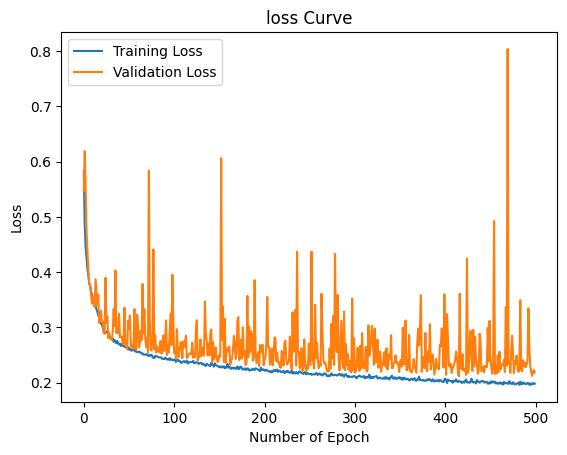

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss Curve")
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.legend(['Training Loss','Validation Loss'])

In [ ]:
#model = load_model('/content/drive/My Drive/Apnea Data/St. Vincent Hospital/Saved Models/finalModel12Sec_10Thresh_SMOTE_VincenctandApnea.hdf5')
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


In [ ]:
for layer in model.layers:
    # Print the layer name and weight tensor shape (if it has weights)
    if layer.weights:
        print(layer.name, layer.get_weights()[0].shape)

batch_normalization_24 (1,)
conv1d_68 (3, 1, 3)
conv1d_69 (3, 3, 50)
conv1d_70 (3, 50, 20)
conv1d_71 (3, 20, 20)
conv1d_72 (3, 20, 3)
conv1d_73 (3, 3, 5)
batch_normalization_25 (5,)
batch_normalization_26 (190,)
dense_7 (190, 1)


In [ ]:
test_segment = xTestFinal[9:10]
test_segment=test_segment.reshape(1,test_segment.shape[1],test_segment.shape[0])
test_segment.shape

(1, 1536, 1)

In [ ]:
activations = activation_model.predict(test_segment)
for i, layer_activation in enumerate(activations):
    print(f'{i+1}:\n{layer_activation.shape}')
    if i==13:
      flatten = layer_activation
flatten

1/1 [==============================] - 0s 23ms/step
1:
(1, 1536, 1)
2:
(1, 1536, 1)
3:
(1, 768, 2)
4:
(1, 383, 50)
5:
(1, 191, 50)
6:
(1, 189, 20)
7:
(1, 187, 20)
8:
(1, 185, 20)
9:
(1, 184, 20)
10:
(1, 92, 2)
11:
(1, 90, 2)
12:
(1, 88, 5)
13:
(1, 43, 5)
14:
(1, 43, 5)
15:
(1, 215)
16:
(1, 215)
17:
(1, 1)


array([[[ 0.894271  ,  0.0016251 , -0.14094672,  0.8680078 ,
          0.00323842],
        [ 0.894271  ,  0.0016251 , -0.14094672,  0.8680078 ,
          0.00323842],
        [ 0.01735163,  0.0016251 , -0.14094672,  0.13747644,
          0.00323842],
        [-0.11294651,  0.0016251 , -0.14094672, -0.13330507,
          0.00323842],
        [ 0.23420441,  0.0016251 , -0.14094672,  0.20154774,
          0.00323842],
        [ 0.36441028,  0.0016251 , -0.14094672,  0.26539457,
          0.00323842],
        [ 0.15403318,  0.0016251 , -0.14094672,  0.25630045,
          0.00323842],
        [-0.09018862,  0.0016251 , -0.14094672, -0.13672543,
          0.00323842],
        [ 0.97859776,  0.0016251 , -0.14094672,  1.3077716 ,
          0.00323842],
        [ 1.3169185 ,  0.0016251 , -0.14094672,  1.3077716 ,
          0.00323842],
        [ 0.9443873 ,  0.0016251 , -0.14094672,  0.82119596,
          0.00323842],
        [-0.04801321,  0.0016251 , -0.14094672, -0.17353511,
          0.003

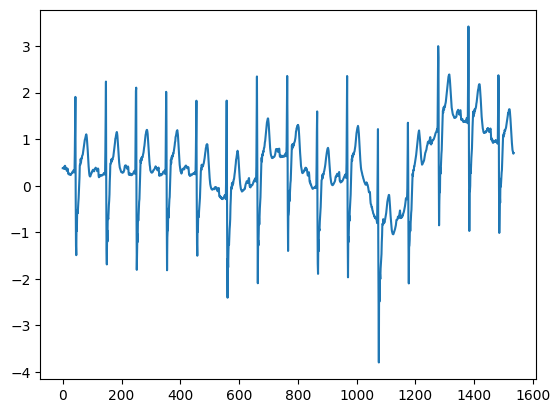

In [ ]:
plt.plot(xTestFinal[1])

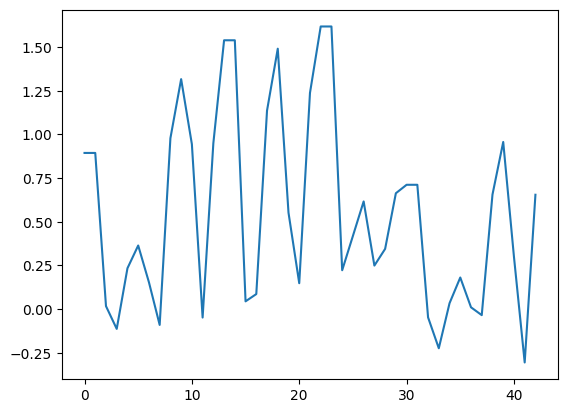

In [ ]:
plt.plot(flatten[0][:,0])

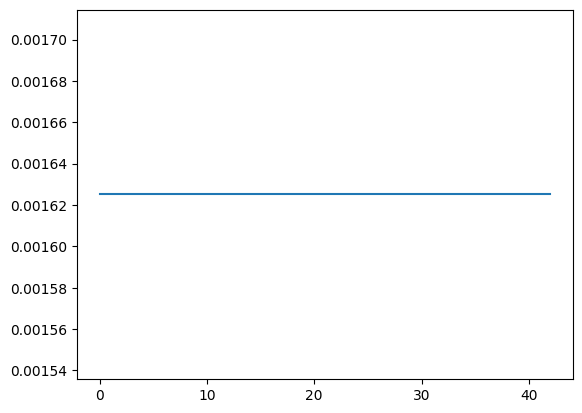

In [ ]:
plt.plot(flatten[0][:,1])

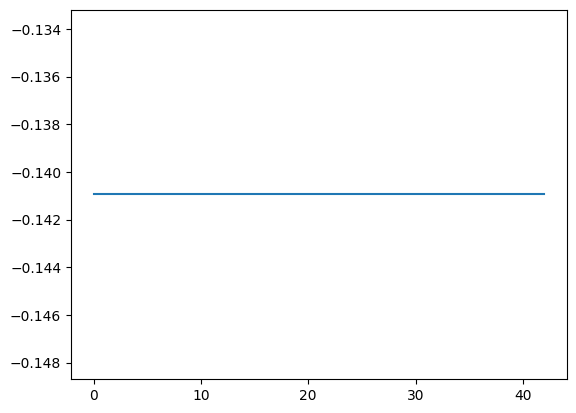

In [ ]:
plt.plot(flatten[0][:,2])

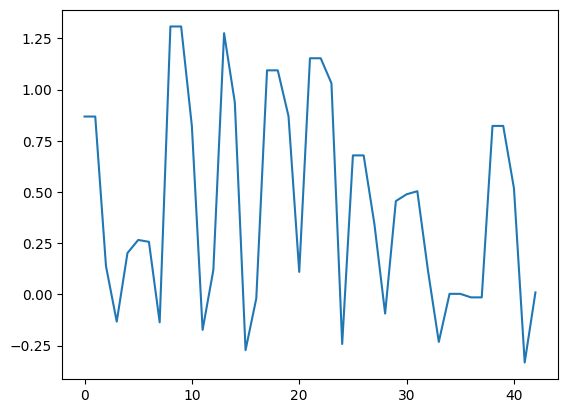

In [ ]:
plt.plot(flatten[0][:,3])

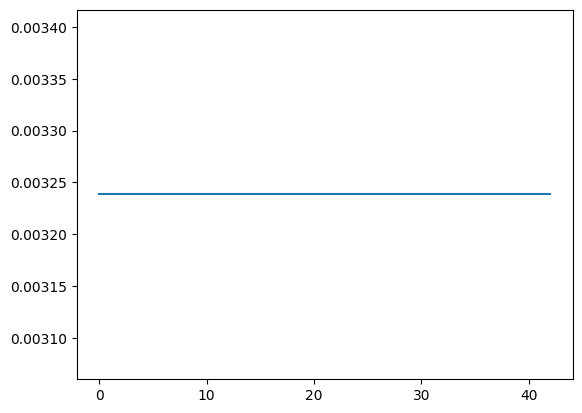

In [ ]:
plt.plot(flatten[0][:,4])

In [ ]:
#Evaluate the model on Test Data
loss, acc = model.evaluate(xTestFinal,yTestFinal)

419/419 [==============================] - 1s 3ms/step - loss: 0.2162 - binary_accuracy: 0.9197


In [ ]:
# Create the perfromance metrics for Test Data
yPredict = model.predict(xTestFinal)
yPredictTransform = np.argmax(yPredict, axis =1)
yTestTransform = np.argmax(yTestFinal, axis =1)
resultMatrix = confusion_matrix(yTestTransform, yPredictTransform)
resultReport = classification_report(yTestTransform, yPredictTransform)
print(resultMatrix)
print(resultReport)

419/419 [==============================] - 1s 3ms/step
[[6309  422]
 [ 244 6417]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6731
           1       0.94      0.96      0.95      6661

    accuracy                           0.95     13392
   macro avg       0.95      0.95      0.95     13392
weighted avg       0.95      0.95      0.95     13392



In [ ]:
# Produce the performance metrics
TN = resultMatrix[0][0]
FN = resultMatrix[1][0]
TP = resultMatrix[1][1]
FP = resultMatrix[0][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+TN+FP+FN)
print(f'Precision:{precision}, Recall:{recall}, Specificity:{specificity}, Accuracy:{accuracy}')

Precision:0.9382950723790028, Recall:0.9633688635340039, Specificity:0.9373050066854851, Accuracy:0.9502688172043011


In [ ]:
# produce additional metrix, AUC
fpr, tpr, thresholds = roc_curve(yTestTransform, yPredict[:,1])
Auc=auc(fpr, tpr)
print(f'The AUC score of the model is: {Auc}')

The AUC score of the model is: 0.9890110092315653


Text(0.5, 1.0, 'ROC Curve')

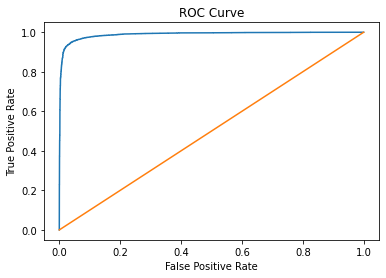

In [ ]:
# plot the ROC Curve
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [ ]:
# Record name for ApneaECG dataset
path = '/content/drive/My Drive/Apnea Data/apnea-ecg-database-1.0.0/'
A1 = ["a0%d" %i for i in range(1,10)]
A2 = ["a%d" %i for i in range(10,21)]
B = ["b0%d" %i for i in range(1,6)]
C = ["c0%d" %i for i in range(1,10)]
X1 = ["x0%d" %i for i in range(1,10)]
X2 = ["x%d" %i for i in range(10,36)]
Record = [A1 + A2 + B + C + ["c10"] + X1 + X2][0]

In [ ]:
# segmentation of the signal into segments of 15s
storeSegment = []
storeAnnotation = []
minute = 6000
fs = 100
segmentLength = int(15.36*fs)
for record in Record:
  fileIn = path + record
  annot_apnea = wfdb.io.rdann(fileIn, 'apn')
  annotation = annot_apnea.symbol
  signal, info= wfdb.io.rdsamp(fileIn)
  for j in range(len(annotation)):
    minuteSignal = signal[j*minute:j*minute+minute].ravel()
    windowSignal = list(minuteSignal[:segmentLength])
    if len(windowSignal)==segmentLength:
      storeSegment.append(windowSignal)
      storeAnnotation += annotation[j]
  if record == 'c10':
    trainLen = len(storeSegment)
    print(f'Total number of Training Segment: {trainLen}')
  if record == 'x35':
    print(f'Total number of Testing Segment: {len(storeSegment)-trainLen}')

Total number of Training Segment: 17035
Total number of Testing Segment: 17263


In [ ]:
# Standardizing the APNEA-ECG data and reshape
scale = StandardScaler()
xNorm = scale.fit_transform(storeSegment)
xApneaECG = np.reshape(xNorm,(xNorm.shape[0],xNorm.shape[1],1))
yApneaECG = np.array([[1,0] if i=='N' else [0,1] for i in storeAnnotation])

In [ ]:
# Dividing the set into train and test
xApneaECGTrain = xApneaECG[:17035,:,:]
yApneaECGTrain = yApneaECG[:17035,:]
xApneaECGTest = xApneaECG[17035:,:,:]
yApneaECGTest = yApneaECG[17035:,:]

In [ ]:
# load the model
modelLoaded =load_model('/content/drive/My Drive/Apnea Data/St. Vincent Hospital/Saved Models/finalModel12Sec_10Thresh_SMOTE.hdf5')

In [ ]:
loss, acc = modelLoaded.evaluate(xTestFinal,yTestFinal)

286/286 [==============================] - 2s 5ms/step - loss: 0.4730 - binary_accuracy: 0.9688


In [ ]:
# Re-train the model
# Compile and fit the model
modelLoaded.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy()])
historyRetrain=modelLoaded.fit(xApneaECGTrain, yApneaECGTrain, epochs=200, batch_size=1024, validation_split=0.2, verbose=1)

Epoch 1/200
14/14 [==============================] - 4s 171ms/step - loss: 0.5008 - binary_accuracy: 0.9516 - val_loss: 0.5336 - val_binary_accuracy: 0.9962
Epoch 2/200
14/14 [==============================] - 2s 148ms/step - loss: 0.4779 - binary_accuracy: 0.9786 - val_loss: 0.5269 - val_binary_accuracy: 0.9436
Epoch 3/200
14/14 [==============================] - 2s 148ms/step - loss: 0.4683 - binary_accuracy: 0.9858 - val_loss: 0.6535 - val_binary_accuracy: 0.7109
Epoch 4/200
14/14 [==============================] - 2s 149ms/step - loss: 0.4692 - binary_accuracy: 0.9838 - val_loss: 0.6277 - val_binary_accuracy: 0.7502
Epoch 5/200
14/14 [==============================] - 2s 150ms/step - loss: 0.4627 - binary_accuracy: 0.9907 - val_loss: 0.6444 - val_binary_accuracy: 0.7364
Epoch 6/200
14/14 [==============================] - 2s 150ms/step - loss: 0.4632 - binary_accuracy: 0.9888 - val_loss: 0.7504 - val_binary_accuracy: 0.6026
Epoch 7/200
14/14 [==============================] - 2s 15